#**CELL 1 - Setup & Load Preprocessed Data**

In [1]:
# ============================================================================
# CELL 1: Setup & Load Preprocessed Data (PIPELINE A)
# ============================================================================

import pandas as pd
import numpy as np
from pathlib import Path
import json
import pickle
import time
import warnings
warnings.filterwarnings('ignore')

# Models
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
try:
    from xgboost import XGBRegressor
    HAS_XGB = True
except Exception:
    HAS_XGB = False

# Metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

# Viz
import matplotlib.pyplot as plt
import seaborn as sns

print("=" * 80)
print("IMPETUS MODELING A - PERFORMANCE SCORE REGRESSION (PIPELINE A)")
print("=" * 80)
print()

# --------------------------------------------------------------------------
# CONFIG
# --------------------------------------------------------------------------
PIPELINE_KEY = "A"
TARGET_COL = "performance_score_0_10"
META_COLS = ["user_id", "date", "experience_label"]

DATA_DIR = Path("data/synth_set_level_v2")
MODEL_DIR = Path("models")
VIZ_DIR = Path("visualizations")
MODEL_DIR.mkdir(exist_ok=True)
VIZ_DIR.mkdir(exist_ok=True)

train_path = DATA_DIR / "impetus_train_A.csv"
test_path  = DATA_DIR / "impetus_test_A.csv"

train_df = pd.read_csv(train_path, parse_dates=["date"])
test_df  = pd.read_csv(test_path,  parse_dates=["date"])

print(f"Train: {train_df.shape} | {train_df['date'].min().date()} -> {train_df['date'].max().date()}")
print(f"Test : {test_df.shape} | {test_df['date'].min().date()} -> {test_df['date'].max().date()}")
print()

# Load metadata
with open(MODEL_DIR / "impetus_feature_metadata.json", "r") as f:
    metadata = json.load(f)

feature_cols = metadata["pipelines"][PIPELINE_KEY]["feature_cols"]

# Guardrail: escludi sempre meta + target (anche se per errore fossero dentro)
ban_cols = set(META_COLS + ["performance_score_0_10", "injury_risk_score"])
feature_cols = [c for c in feature_cols if c not in ban_cols]

print(f"Features (da metadata, filtrate): {len(feature_cols)}")
print()

# Prepare X, y (NB: i dati sono già scalati dalla FE)
train_df = train_df.sort_values("date").reset_index(drop=True)
test_df  = test_df.sort_values("date").reset_index(drop=True)

X_train = train_df[feature_cols].copy()
y_train = train_df[TARGET_COL].copy()
X_test  = test_df[feature_cols].copy()
y_test  = test_df[TARGET_COL].copy()

print("SHAPES:")
print(f"  X_train: {X_train.shape}")
print(f"  y_train: {y_train.shape}, range [{y_train.min():.2f}, {y_train.max():.2f}]")
print(f"  X_test : {X_test.shape}")
print(f"  y_test : {y_test.shape}, range [{y_test.min():.2f}, {y_test.max():.2f}]")
print()

print("TARGET STATISTICS:")
print(f"  Train mean: {y_train.mean():.2f}, std: {y_train.std():.2f}")
print(f"  Test  mean: {y_test.mean():.2f}, std: {y_test.std():.2f}")
print(f"  Distribution shift (mean abs diff): {abs(y_train.mean() - y_test.mean()):.2f}")
print()

print("EXPERIENCE DISTRIBUTION (Train vs Test):")
tr_exp = train_df["experience_label"].value_counts(normalize=True) * 100
te_exp = test_df["experience_label"].value_counts(normalize=True) * 100
levels = sorted(set(tr_exp.index) | set(te_exp.index))
for lvl in levels:
    print(f"  {lvl:15s}: Train {tr_exp.get(lvl,0):5.1f}%, Test {te_exp.get(lvl,0):5.1f}%")


IMPETUS MODELING A - PERFORMANCE SCORE REGRESSION (PIPELINE A)

Train: (68694, 39) | 2023-05-06 -> 2025-11-19
Test : (17131, 39) | 2025-11-20 -> 2026-02-08

Features (da metadata, filtrate): 35

SHAPES:
  X_train: (68694, 35)
  y_train: (68694,), range [0.06, 10.00]
  X_test : (17131, 35)
  y_test : (17131,), range [0.09, 10.00]

TARGET STATISTICS:
  Train mean: 3.71, std: 2.58
  Test  mean: 3.69, std: 3.33
  Distribution shift (mean abs diff): 0.02

EXPERIENCE DISTRIBUTION (Train vs Test):
  Advanced       : Train  69.5%, Test  36.4%
  Beginner       : Train   3.1%, Test  28.0%
  Intermediate   : Train  27.4%, Test  35.6%


#**CELL 2 - Ridge Regression (WITH Lag)**

In [2]:
# ============================================================================
# CELL 2: Ridge Regression (WITH Lag) - α Tuning (TimeSeriesSplit CV)
# ============================================================================

print("\n" + "=" * 80)
print("SECTION 1: WITH LAG FEATURES - MODELING")
print("=" * 80)
print()
print("MODEL 1: RIDGE REGRESSION (L2 Regularization)")
print("-" * 80)

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

def smape(y_true, y_pred, eps=1e-8):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    denom = np.maximum((np.abs(y_true) + np.abs(y_pred)) / 2.0, eps)
    return np.mean(np.abs(y_true - y_pred) / denom) * 100

def mape_clipped(y_true, y_pred, denom_min=1.0):
    """
    MAPE stabile su scala 0-10: evita esplosioni quando y_true ~ 0.
    denom_min=1.0 significa: sotto 1 punto di score, normalizzi comunque su 1.
    """
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    denom = np.maximum(np.abs(y_true), denom_min)
    return np.mean(np.abs(y_true - y_pred) / denom) * 100

def regression_metrics(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mape_clipped(y_true, y_pred, denom_min=1.0)
    smape_val = smape(y_true, y_pred)
    return r2, mae, rmse, mape, smape_val

# Time-aware CV (sui dati ordinati per data)
tscv = TimeSeriesSplit(n_splits=3)

param_grid = {"alpha": [0.1, 1.0, 10.0]}
ridge = Ridge(random_state=42)
grid_search = GridSearchCV(
    ridge,
    param_grid,
    cv=tscv,
    scoring="r2",
    n_jobs=-1
)

t0 = time.time()
grid_search.fit(X_train, y_train)
train_time_ridge = time.time() - t0

best_ridge = grid_search.best_estimator_
best_alpha = grid_search.best_params_["alpha"]

print(f"Best α: {best_alpha} (TimeSeriesSplit CV)")
print(f"Training time: {train_time_ridge:.2f}s")
print()

y_train_pred_ridge = best_ridge.predict(X_train)
y_test_pred_ridge  = best_ridge.predict(X_test)

(r2_train_ridge, mae_train_ridge, rmse_train_ridge,
 mape_train_ridge, smape_train_ridge) = regression_metrics(y_train, y_train_pred_ridge)

(r2_test_ridge, mae_test_ridge, rmse_test_ridge,
 mape_test_ridge, smape_test_ridge) = regression_metrics(y_test, y_test_pred_ridge)

gap_ridge = r2_train_ridge - r2_test_ridge

print("RESULTS:")
print(f"  R² Train: {r2_train_ridge:.4f}")
print(f"  R² Test : {r2_test_ridge:.4f}")
print(f"  Train-Test Gap: {gap_ridge:.4f}")
print(f"  MAE Test : {mae_test_ridge:.3f} (scala 0-10)")
print(f"  RMSE Test: {rmse_test_ridge:.3f}")
print(f"  MAPE Test: {mape_test_ridge:.1f}%")
print(f"  sMAPE Test: {smape_test_ridge:.1f}%")



SECTION 1: WITH LAG FEATURES - MODELING

MODEL 1: RIDGE REGRESSION (L2 Regularization)
--------------------------------------------------------------------------------
Best α: 0.1 (TimeSeriesSplit CV)
Training time: 2.68s

RESULTS:
  R² Train: 0.9997
  R² Test : 0.9994
  Train-Test Gap: 0.0003
  MAE Test : 0.038 (scala 0-10)
  RMSE Test: 0.081
  MAPE Test: 1.5%
  sMAPE Test: 2.8%


#**CELL 3 - Decision Tree Regressor (WITH Lag)**

In [3]:
# ============================================================================
# CELL 3: Decision Tree Regressor (WITH Lag)
# ============================================================================
"""
Baseline interpretabile, no multicollinearity issue.
"""

print("\n" + "=" * 80)
print("MODEL 2: DECISION TREE REGRESSOR")
print("-" * 80)

dt = DecisionTreeRegressor(max_depth=10, min_samples_split=50, random_state=42)

t0 = time.time()
dt.fit(X_train, y_train)
train_time_dt = time.time() - t0

print(f"Training time: {train_time_dt:.2f}s")
print()

# Predictions
y_train_pred_dt = dt.predict(X_train)
y_test_pred_dt = dt.predict(X_test)

# Metrics
r2_train_dt = r2_score(y_train, y_train_pred_dt)
r2_test_dt = r2_score(y_test, y_test_pred_dt)
mae_test_dt = mean_absolute_error(y_test, y_test_pred_dt)
rmse_test_dt = np.sqrt(mean_squared_error(y_test, y_test_pred_dt))
mape_test_dt = np.mean(np.abs((y_test - y_test_pred_dt) / (y_test + 1e-10))) * 100
gap_dt = r2_train_dt - r2_test_dt

print("RESULTS:")
print(f"   R² Train: {r2_train_dt:.4f}")
print(f"   R² Test: {r2_test_dt:.4f}")
print(f"   Train-Test Gap: {gap_dt:.4f}")
print(f"   MAE Test: {mae_test_dt:.3f}")
print(f"   RMSE Test: {rmse_test_dt:.3f}")
print(f"   MAPE Test: {mape_test_dt:.1f}%")


MODEL 2: DECISION TREE REGRESSOR
--------------------------------------------------------------------------------
Training time: 4.48s

RESULTS:
   R² Train: 0.9997
   R² Test: 0.9997
   Train-Test Gap: -0.0000
   MAE Test: 0.034
   RMSE Test: 0.054
   MAPE Test: 2.0%


#**CELL 4 - Random Forest Regressor (WITH Lag)**

In [4]:
# ============================================================================
# CELL 4: Random Forest Regressor (WITH Lag)
# ============================================================================
"""
Ensemble robusto, tollerante a multicollinearity.
"""

print("\n" + "=" * 80)
print("MODEL 3: RANDOM FOREST REGRESSOR")
print("-" * 80)

rf = RandomForestRegressor(n_estimators=100, max_depth=15, min_samples_split=20,
                           random_state=42, n_jobs=-1)

t0 = time.time()
rf.fit(X_train, y_train)
train_time_rf = time.time() - t0

print(f"Training time: {train_time_rf:.2f}s")
print()

# Predictions
y_train_pred_rf = rf.predict(X_train)
y_test_pred_rf = rf.predict(X_test)

# Metrics
r2_train_rf = r2_score(y_train, y_train_pred_rf)
r2_test_rf = r2_score(y_test, y_test_pred_rf)
mae_test_rf = mean_absolute_error(y_test, y_test_pred_rf)
rmse_test_rf = np.sqrt(mean_squared_error(y_test, y_test_pred_rf))
mape_test_rf = np.mean(np.abs((y_test - y_test_pred_rf) / (y_test + 1e-10))) * 100
gap_rf = r2_train_rf - r2_test_rf

print("RESULTS:")
print(f"   R² Train: {r2_train_rf:.4f}")
print(f"   R² Test: {r2_test_rf:.4f}")
print(f"   Train-Test Gap: {gap_rf:.4f}")
print(f"   MAE Test: {mae_test_rf:.3f}")
print(f"   RMSE Test: {rmse_test_rf:.3f}")
print(f"   MAPE Test: {mape_test_rf:.1f}%")


MODEL 3: RANDOM FOREST REGRESSOR
--------------------------------------------------------------------------------
Training time: 263.53s

RESULTS:
   R² Train: 0.9999
   R² Test: 0.9999
   Train-Test Gap: 0.0001
   MAE Test: 0.022
   RMSE Test: 0.037
   MAPE Test: 1.2%


#**CELL 5 - Gradient Boosting Regressor (WITH Lag)**

In [5]:
# ============================================================================
# CELL 5: Gradient Boosting Regressor (WITH Lag)
# ============================================================================
"""
Best in STATUS (96.1%), sequential boosting.
"""

print("\n" + "=" * 80)
print("MODEL 4: GRADIENT BOOSTING REGRESSOR")
print("-" * 80)

gb = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=5,
                               min_samples_split=20, random_state=42)

t0 = time.time()
gb.fit(X_train, y_train)
train_time_gb = time.time() - t0

print(f"Training time: {train_time_gb:.2f}s")
print()

# Predictions
y_train_pred_gb = gb.predict(X_train)
y_test_pred_gb = gb.predict(X_test)

# Metrics
r2_train_gb = r2_score(y_train, y_train_pred_gb)
r2_test_gb = r2_score(y_test, y_test_pred_gb)
mae_test_gb = mean_absolute_error(y_test, y_test_pred_gb)
rmse_test_gb = np.sqrt(mean_squared_error(y_test, y_test_pred_gb))
mape_test_gb = np.mean(np.abs((y_test - y_test_pred_gb) / (y_test + 1e-10))) * 100
gap_gb = r2_train_gb - r2_test_gb

print("RESULTS:")
print(f"   R² Train: {r2_train_gb:.4f}")
print(f"   R² Test: {r2_test_gb:.4f}")
print(f"   Train-Test Gap: {gap_gb:.4f}")
print(f"   MAE Test: {mae_test_gb:.3f}")
print(f"   RMSE Test: {rmse_test_gb:.3f}")
print(f"   MAPE Test: {mape_test_gb:.1f}%")


MODEL 4: GRADIENT BOOSTING REGRESSOR
--------------------------------------------------------------------------------
Training time: 278.50s

RESULTS:
   R² Train: 0.9999
   R² Test: 0.9999
   Train-Test Gap: 0.0000
   MAE Test: 0.018
   RMSE Test: 0.028
   MAPE Test: 1.1%


#**CELL 6 - XGBoost Regressor (WITH Lag)**

In [6]:
# ============================================================================
# CELL 6: XGBoost Regressor (WITH Lag)
# ============================================================================
"""
Advanced ensemble, optional se tempo disponibile.
"""

print("\n" + "=" * 80)
print("MODEL 5: XGBOOST REGRESSOR (Optional)")
print("-" * 80)

xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5,
                   random_state=42, n_jobs=-1)

t0 = time.time()
xgb.fit(X_train, y_train)
train_time_xgb = time.time() - t0

print(f"Training time: {train_time_xgb:.2f}s")
print()

# Predictions
y_train_pred_xgb = xgb.predict(X_train)
y_test_pred_xgb = xgb.predict(X_test)

# Metrics
r2_train_xgb = r2_score(y_train, y_train_pred_xgb)
r2_test_xgb = r2_score(y_test, y_test_pred_xgb)
mae_test_xgb = mean_absolute_error(y_test, y_test_pred_xgb)
rmse_test_xgb = np.sqrt(mean_squared_error(y_test, y_test_pred_xgb))
mape_test_xgb = np.mean(np.abs((y_test - y_test_pred_xgb) / (y_test + 1e-10))) * 100
gap_xgb = r2_train_xgb - r2_test_xgb

print("RESULTS:")
print(f"   R² Train: {r2_train_xgb:.4f}")
print(f"   R² Test: {r2_test_xgb:.4f}")
print(f"   Train-Test Gap: {gap_xgb:.4f}")
print(f"   MAE Test: {mae_test_xgb:.3f}")
print(f"   RMSE Test: {rmse_test_xgb:.3f}")
print(f"   MAPE Test: {mape_test_xgb:.1f}%")



MODEL 5: XGBOOST REGRESSOR (Optional)
--------------------------------------------------------------------------------
Training time: 2.08s

RESULTS:
   R² Train: 0.9999
   R² Test: 0.9999
   Train-Test Gap: -0.0000
   MAE Test: 0.019
   RMSE Test: 0.031
   MAPE Test: 1.2%


#**CELL 7 - WITH LAG - Model Comparison & Best Model Selection**

In [7]:
# ============================================================================
# CELL 7: WITH LAG - Model Comparison & Best Model Selection (robusto)
# ============================================================================

print("\n" + "=" * 80)
print("WITH LAG - MODEL COMPARISON")
print("=" * 80)

# Colleziona risultati in modo robusto
models_list = [
    ("Ridge",            r2_train_ridge, r2_test_ridge, gap_ridge, mae_test_ridge, rmse_test_ridge, mape_test_ridge, train_time_ridge),
    ("Decision Tree",    r2_train_dt,    r2_test_dt,    gap_dt,    mae_test_dt,    rmse_test_dt,    mape_test_dt,    train_time_dt),
    ("Random Forest",    r2_train_rf,    r2_test_rf,    gap_rf,    mae_test_rf,    rmse_test_rf,    mape_test_rf,    train_time_rf),
    ("Gradient Boosting",r2_train_gb,    r2_test_gb,    gap_gb,    mae_test_gb,    rmse_test_gb,    mape_test_gb,    train_time_gb),
]

if "r2_test_xgb" in globals():
    models_list.append(
        ("XGBoost", r2_train_xgb, r2_test_xgb, gap_xgb, mae_test_xgb, rmse_test_xgb, mape_test_xgb, train_time_xgb)
    )

results_with_lag = pd.DataFrame(models_list, columns=[
    "Model", "R²_Train", "R²_Test", "Gap", "MAE_Test", "RMSE_Test", "MAPE_Test", "Time(s)"
])

print("\nCOMPARISON TABLE:")
print(results_with_lag.to_string(index=False))
print()

# Best model selection (highest R²_Test)
best_idx = results_with_lag["R²_Test"].idxmax()
best_model_name = results_with_lag.loc[best_idx, "Model"]
best_r2 = float(results_with_lag.loc[best_idx, "R²_Test"])
best_mae = float(results_with_lag.loc[best_idx, "MAE_Test"])
best_gap = float(results_with_lag.loc[best_idx, "Gap"])

print("=" * 80)
print("BEST MODEL WITH LAG:")
print(f"  Model: {best_model_name}")
print(f"  R² Test: {best_r2:.4f}")
print(f"  MAE Test: {best_mae:.3f}")
print(f"  Train-Test Gap: {best_gap:.4f}")
print("=" * 80)

# Mappa nome -> oggetto modello per salvataggio
model_map = {
    "Ridge": best_ridge,
    "Decision Tree": dt,
    "Random Forest": rf,
    "Gradient Boosting": gb,
}
if "xgb" in globals():
    model_map["XGBoost"] = xgb

best_model_with_lag = model_map[best_model_name]



WITH LAG - MODEL COMPARISON

COMPARISON TABLE:
            Model  R²_Train  R²_Test           Gap  MAE_Test  RMSE_Test  MAPE_Test    Time(s)
            Ridge  0.999709 0.999400  3.083019e-04  0.038456   0.081426   1.489247   2.678225
    Decision Tree  0.999728 0.999732 -4.153467e-06  0.034342   0.054445   2.047644   4.484267
    Random Forest  0.999945 0.999878  6.756431e-05  0.021631   0.036790   1.240270 263.532580
Gradient Boosting  0.999934 0.999929  5.367873e-06  0.017898   0.028098   1.084652 278.496081
          XGBoost  0.999913 0.999914 -9.029833e-07  0.019246   0.030923   1.175819   2.077718

BEST MODEL WITH LAG:
  Model: Gradient Boosting
  R² Test: 0.9999
  MAE Test: 0.018
  Train-Test Gap: 0.0000


#**CELL 8 - WITHOUT LAG - Feature Preparation & Modeling**

In [8]:
# ============================================================================
# CELL 8: WITHOUT LAG - Feature Preparation & Modeling (ablation)
# ============================================================================

print("\n" + "=" * 80)
print("SECTION 2: WITHOUT LAG FEATURES - ABLATION STUDY")
print("=" * 80)

features_no_lag = [c for c in feature_cols if "_lag_" not in c.lower()]

print(f"\nFeatures WITH lag: {len(feature_cols)}")
print(f"Features NO lag  : {len(features_no_lag)}")
print(f"Features removed : {len(feature_cols) - len(features_no_lag)}")
print()

X_train_no_lag = train_df[features_no_lag]
X_test_no_lag  = test_df[features_no_lag]

print(f"X_train_no_lag: {X_train_no_lag.shape}")
print(f"X_test_no_lag : {X_test_no_lag.shape}")
print()

# Ridge NO lag
print("MODEL 1: Ridge Regression (NO lag)")
grid_search_no_lag = GridSearchCV(Ridge(random_state=42), param_grid, cv=tscv, scoring="r2", n_jobs=-1)
grid_search_no_lag.fit(X_train_no_lag, y_train)
best_ridge_no_lag = grid_search_no_lag.best_estimator_
y_test_pred_ridge_no_lag = best_ridge_no_lag.predict(X_test_no_lag)
(r2_test_ridge_no_lag, mae_test_ridge_no_lag,
 rmse_test_ridge_no_lag, mape_test_ridge_no_lag,
 smape_test_ridge_no_lag) = regression_metrics(y_test, y_test_pred_ridge_no_lag)
print(f"  R² Test: {r2_test_ridge_no_lag:.4f}, MAE: {mae_test_ridge_no_lag:.3f}")
print()

# RF NO lag
print("MODEL 2: Random Forest (NO lag)")
rf_no_lag = RandomForestRegressor(n_estimators=100, max_depth=15, min_samples_split=20,
                                  random_state=42, n_jobs=-1)
rf_no_lag.fit(X_train_no_lag, y_train)
y_test_pred_rf_no_lag = rf_no_lag.predict(X_test_no_lag)
(r2_test_rf_no_lag, mae_test_rf_no_lag,
 rmse_test_rf_no_lag, mape_test_rf_no_lag,
 smape_test_rf_no_lag) = regression_metrics(y_test, y_test_pred_rf_no_lag)
print(f"  R² Test: {r2_test_rf_no_lag:.4f}, MAE: {mae_test_rf_no_lag:.3f}")
print()

# GB NO lag
print("MODEL 3: Gradient Boosting (NO lag)")
gb_no_lag = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=5,
                                      min_samples_split=20, random_state=42)
gb_no_lag.fit(X_train_no_lag, y_train)
y_test_pred_gb_no_lag = gb_no_lag.predict(X_test_no_lag)
(r2_test_gb_no_lag, mae_test_gb_no_lag,
 rmse_test_gb_no_lag, mape_test_gb_no_lag,
 smape_test_gb_no_lag) = regression_metrics(y_test, y_test_pred_gb_no_lag)
print(f"  R² Test: {r2_test_gb_no_lag:.4f}, MAE: {mae_test_gb_no_lag:.3f}")
print()


results_no_lag = {
    "Ridge": r2_test_ridge_no_lag,
    "Random Forest": r2_test_rf_no_lag,
    "Gradient Boosting": r2_test_gb_no_lag
}
best_model_name_no_lag = max(results_no_lag, key=results_no_lag.get)
best_r2_no_lag = results_no_lag[best_model_name_no_lag]

print("=" * 80)
print("BEST MODEL WITHOUT LAG:")
print(f"  Model: {best_model_name_no_lag}")
print(f"  R² Test: {best_r2_no_lag:.4f}")
print("=" * 80)



SECTION 2: WITHOUT LAG FEATURES - ABLATION STUDY

Features WITH lag: 35
Features NO lag  : 25
Features removed : 10

X_train_no_lag: (68694, 25)
X_test_no_lag : (17131, 25)

MODEL 1: Ridge Regression (NO lag)
  R² Test: 0.7418, MAE: 0.516

MODEL 2: Random Forest (NO lag)
  R² Test: 0.9997, MAE: 0.031

MODEL 3: Gradient Boosting (NO lag)
  R² Test: 0.9998, MAE: 0.031

BEST MODEL WITHOUT LAG:
  Model: Gradient Boosting
  R² Test: 0.9998


#**CELL ablation mirata**

In [9]:
# ============================================================================
# Ablation mirata - drop performance_score_0_10_lag_7d
# ============================================================================

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
import time

print("\n" + "=" * 80)
print("ABLATION MIRATA (PIPELINE A): DROP performance_score_0_10_lag_7d")
print("=" * 80)

drop_1 = ["performance_score_0_10_lag_7d"]
drop_2 = ["performance_score_0_10_lag_7d", "performance_score_0_10_lag_14d"]

variants = {
    "baseline_WITH_lag": feature_cols,
    "drop_perf_lag_7d": [c for c in feature_cols if c not in drop_1],
    "drop_perf_lag_7d_14d": [c for c in feature_cols if c not in drop_2],
}

rows = []

# Time-aware CV per Ridge
tscv = TimeSeriesSplit(n_splits=3)
param_grid = {"alpha": [0.1, 1.0, 10.0]}

for vname, feats in variants.items():
    Xtr = train_df[feats]
    Xte = test_df[feats]

    # Ridge (con CV)
    ridge = Ridge(random_state=42)
    gs = GridSearchCV(ridge, param_grid, cv=tscv, scoring="r2", n_jobs=-1)
    t0 = time.time()
    gs.fit(Xtr, y_train)
    t_ridge = time.time() - t0
    best_ridge_v = gs.best_estimator_

    pred_tr = best_ridge_v.predict(Xtr)
    pred_te = best_ridge_v.predict(Xte)
    (r2_tr, mae_tr, rmse_tr,
     mape_tr, smape_tr) = regression_metrics(y_train, pred_tr)
    (r2_te, mae_te, rmse_te,
     mape_te, smape_te) = regression_metrics(y_test, pred_te)

    rows.append({
        "Variant": vname,
        "Model": f"Ridge(alpha={gs.best_params_['alpha']})",
        "n_feat": len(feats),
        "R²_Test": r2_te,
        "MAE_Test": mae_te,
        "RMSE_Test": rmse_te,
        "MAPE_Test": mape_te,
        "sMAPE_Test": smape_te,
        "Time(s)": t_ridge
    })

    # Gradient Boosting
    gb = GradientBoostingRegressor(
        n_estimators=50, learning_rate=0.1, max_depth=3,
        min_samples_split=20, random_state=42
    )

    t0 = time.time()
    gb.fit(Xtr, y_train)
    t_gb = time.time() - t0

    pred_te_gb = gb.predict(Xte)
    (r2_te_gb, mae_te_gb, rmse_te_gb,
     mape_te_gb, smape_te_gb) = regression_metrics(y_test, pred_te_gb)

    rows.append({
        "Variant": vname,
        "Model": "GradientBoosting(default)",
        "n_feat": len(feats),
        "R²_Test": r2_te_gb,
        "MAE_Test": mae_te_gb,
        "RMSE_Test": rmse_te_gb,
        "MAPE_Test": mape_te_gb,
        "sMAPE_Test": smape_te_gb,
        "Time(s)": t_gb
    })

results_drop_perf_lag = pd.DataFrame(rows).sort_values(["Variant", "Model"]).reset_index(drop=True)

print("\nRISULTATI (focus su drop lag target):")
print(results_drop_perf_lag.to_string(index=False))

print("\nNOTE:")
print(" - Se la performance peggiora molto quando droppi perf_lag_7d, vuol dire che il modello era fortemente autoregressivo.")
print(" - Se peggiora poco, vuol dire che fitness/rolling/trend contengono già quasi tutta l'informazione necessaria.")



ABLATION MIRATA (PIPELINE A): DROP performance_score_0_10_lag_7d

RISULTATI (focus su drop lag target):
             Variant                     Model  n_feat  R²_Test  MAE_Test  RMSE_Test  MAPE_Test  sMAPE_Test   Time(s)
   baseline_WITH_lag GradientBoosting(default)      35 0.999592  0.050605   0.067128   2.376537    4.160521 86.824497
   baseline_WITH_lag          Ridge(alpha=0.1)      35 0.999400  0.038456   0.081426   1.489247    2.768870  2.376484
    drop_perf_lag_7d GradientBoosting(default)      34 0.999121  0.073113   0.098614   3.395656    5.805886 84.486781
    drop_perf_lag_7d          Ridge(alpha=0.1)      34 0.994730  0.094182   0.241390   2.738279    4.442086  0.319695
drop_perf_lag_7d_14d GradientBoosting(default)      33 0.998674  0.086677   0.121077   3.799613    6.413361 88.140751
drop_perf_lag_7d_14d          Ridge(alpha=0.1)      33 0.733624  0.517788   1.716218  16.663920   24.037135  0.222296

NOTE:
 - Se la performance peggiora molto quando droppi perf_lag_7d,

#**CELL 9 - WITH vs WITHOUT LAG - Comparison & Analysis**

In [10]:
# ============================================================================
# CELL 9: WITH vs WITHOUT LAG - Comparison & Analysis
# ============================================================================
"""
Confronto performance WITH vs WITHOUT lag.
Quantifica quanto lag_7d contribuisce.
"""

print("\n" + "=" * 80)
print("SECTION 3: WITH vs WITHOUT LAG - COMPARISON")
print("=" * 80)

# Comparison table
comparison_df = pd.DataFrame({
    'Condition': ['WITH Lag', 'WITHOUT Lag', 'Difference (Δ)'],
    'Best_Model': [best_model_name, best_model_name_no_lag, '-'],
    'R²_Test': [best_r2, best_r2_no_lag, best_r2 - best_r2_no_lag],
    'MAE_Test': [best_mae,
                 mae_test_ridge_no_lag if best_model_name_no_lag == 'Ridge' else
                 (mae_test_rf_no_lag if best_model_name_no_lag == 'Random Forest' else mae_test_gb_no_lag),
                 '-'],
    'Features': [len(feature_cols), len(features_no_lag), len(feature_cols) - len(features_no_lag)]
})

print("\nCOMPARISON TABLE:")
print(comparison_df.to_string(index=False))
print()

# Analysis
r2_diff = best_r2 - best_r2_no_lag
print("=" * 80)
print("ANALYSIS:")
print(f"   R² improvement WITH lag: +{r2_diff:.4f} ({r2_diff/best_r2_no_lag*100:.1f}% gain)")
print()

if r2_diff > 0.15:
    print("   [INTERPRETATION] Lag features CRITICAL (>15% improvement)")
    print("   → performance_score_lag_7d dominates predictions")
    print("   → Autoregressive model (production forecasting)")
else:
    print("   [INTERPRETATION] Banister features STRONG (modest lag improvement)")
    print("   → fitness, fatigue, ACWR predict well without history")
    print("   → Model captures physiological state")

print()
print("MULTICOLLINEARITY IMPACT:")
print(f"   Ridge R² (WITH lag): {r2_test_ridge:.4f}")
print(f"   GB R² (WITH lag): {r2_test_gb:.4f}")
multicoll_impact = abs(r2_test_gb - r2_test_ridge)
if multicoll_impact < 0.05:
    print(f"   → Multicollinearity impact: {multicoll_impact:.4f} (MINIMAL, non critica)")
else:
    print(f"   → Multicollinearity impact: {multicoll_impact:.4f} (GB advantage, Ridge penalized)")


SECTION 3: WITH vs WITHOUT LAG - COMPARISON

COMPARISON TABLE:
     Condition        Best_Model  R²_Test  MAE_Test  Features
      WITH Lag Gradient Boosting 0.999929  0.017898        35
   WITHOUT Lag Gradient Boosting 0.999782  0.031044        25
Difference (Δ)                 - 0.000146         -        10

ANALYSIS:
   R² improvement WITH lag: +0.0001 (0.0% gain)

   [INTERPRETATION] Banister features STRONG (modest lag improvement)
   → fitness, fatigue, ACWR predict well without history
   → Model captures physiological state

MULTICOLLINEARITY IMPACT:
   Ridge R² (WITH lag): 0.9994
   GB R² (WITH lag): 0.9999
   → Multicollinearity impact: 0.0005 (MINIMAL, non critica)


#**CELL 10 - Visualizations - Predictions & Feature Importance**


VISUALIZATIONS


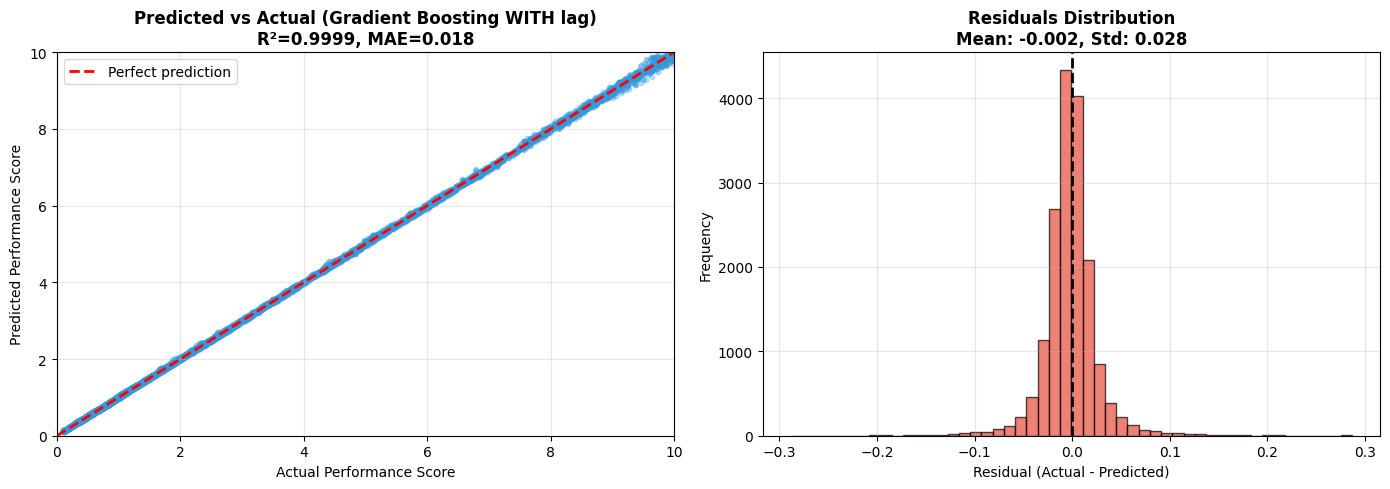

[OK] Visualization 1 saved: IMPETUS_A_Predictions_Residuals.png

FEATURE IMPORTANCE (Top 15):
                      Feature  Importance
performance_score_0_10_lag_7d    0.982638
                      fitness    0.010776
      fitness_rolling_7d_mean    0.004580
                   TSB_x_ACWR    0.000853
            fitness_trend_14d    0.000523
            delta_fitness_28d    0.000369
                        tau_D    0.000049
         acwr_rolling_7d_mean    0.000047
        acwr_rolling_14d_mean    0.000043
        acwr_rolling_28d_mean    0.000025
                        tau_F    0.000019
         acwr_acceleration_7d    0.000017
               impulse_x_acwr    0.000013
                         acwr    0.000013
            delta_impulse_28d    0.000007



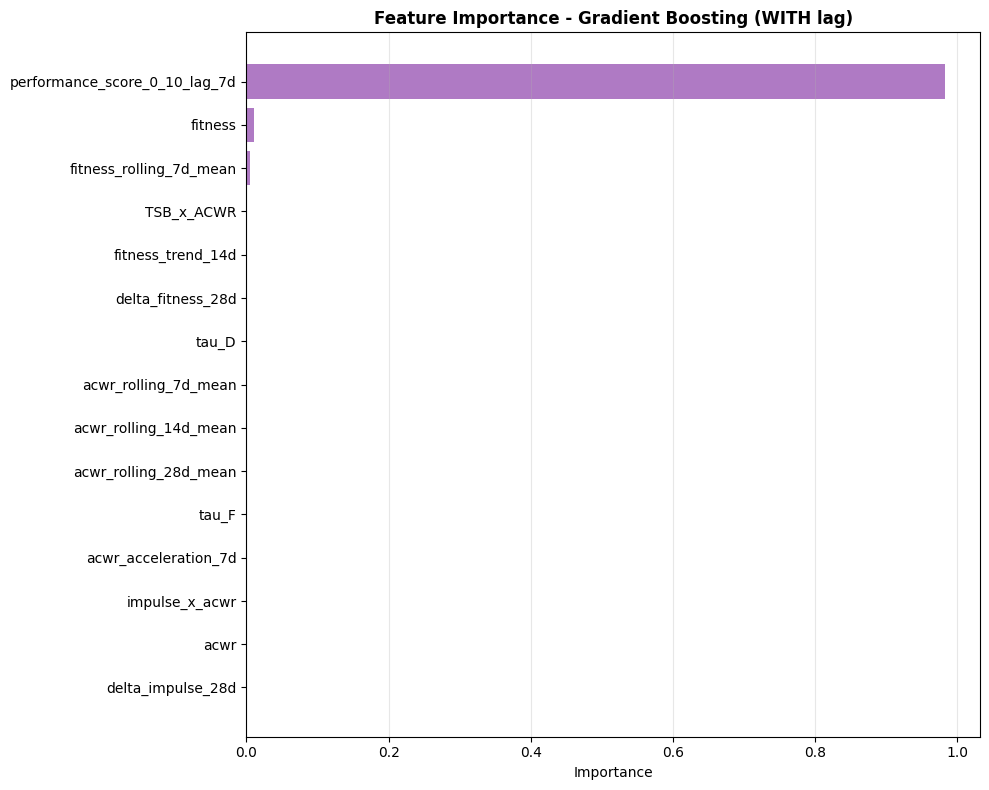

[OK] Visualization 2 saved: IMPETUS_A_Feature_Importance.png


In [11]:
# ============================================================================
# CELL 10: Visualizations - Predictions & Feature Importance
# ============================================================================
"""
Visualizzazioni:
1. Scatter: Predicted vs Actual (best model WITH lag)
2. Residuals histogram
3. Feature importance (if GB/RF best)
"""

print("\n" + "=" * 80)
print("VISUALIZATIONS")
print("=" * 80)

viz_dir = Path('visualizations')
viz_dir.mkdir(exist_ok=True)

# Get best model predictions
if best_model_name == 'Ridge':
    y_test_pred_best = y_test_pred_ridge
elif best_model_name == 'Decision Tree':
    y_test_pred_best = y_test_pred_dt
elif best_model_name == 'Random Forest':
    y_test_pred_best = y_test_pred_rf
elif best_model_name == 'Gradient Boosting':
    y_test_pred_best = y_test_pred_gb
else:
    y_test_pred_best = y_test_pred_xgb

# Figure 1: Predicted vs Actual + Residuals
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Subplot 1: Scatter
axes[0].scatter(y_test, y_test_pred_best, alpha=0.3, s=10, color='#3498db')
axes[0].plot([0, 10], [0, 10], 'r--', linewidth=2, label='Perfect prediction')
axes[0].set_xlabel('Actual Performance Score')
axes[0].set_ylabel('Predicted Performance Score')
axes[0].set_title(f'Predicted vs Actual ({best_model_name} WITH lag)\nR²={best_r2:.4f}, MAE={best_mae:.3f}',
                  fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)
axes[0].set_xlim(0, 10)
axes[0].set_ylim(0, 10)

# Subplot 2: Residuals
residuals = y_test - y_test_pred_best
axes[1].hist(residuals, bins=50, color='#e74c3c', alpha=0.7, edgecolor='black')
axes[1].axvline(0, color='black', linestyle='--', linewidth=2)
axes[1].set_xlabel('Residual (Actual - Predicted)')
axes[1].set_ylabel('Frequency')
axes[1].set_title(f'Residuals Distribution\nMean: {residuals.mean():.3f}, Std: {residuals.std():.3f}',
                  fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(viz_dir / 'IMPETUS_A_Predictions_Residuals.png', dpi=300, bbox_inches='tight')
plt.show()

print("[OK] Visualization 1 saved: IMPETUS_A_Predictions_Residuals.png")
print()

# Figure 2: Feature Importance (if GB or RF)
if best_model_name in ['Gradient Boosting', 'Random Forest']:
    print("FEATURE IMPORTANCE (Top 15):")

    importance = best_model_with_lag.feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': feature_cols,
        'Importance': importance
    }).sort_values('Importance', ascending=False)

    print(feature_importance_df.head(15).to_string(index=False))
    print()

    # Plot
    fig, ax = plt.subplots(figsize=(10, 8))
    top_15 = feature_importance_df.head(15)
    ax.barh(range(15), top_15['Importance'], color='#9b59b6', alpha=0.8)
    ax.set_yticks(range(15))
    ax.set_yticklabels(top_15['Feature'])
    ax.invert_yaxis()
    ax.set_xlabel('Importance')
    ax.set_title(f'Feature Importance - {best_model_name} (WITH lag)', fontweight='bold')
    ax.grid(alpha=0.3, axis='x')

    plt.tight_layout()
    plt.savefig(viz_dir / 'IMPETUS_A_Feature_Importance.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("[OK] Visualization 2 saved: IMPETUS_A_Feature_Importance.png")

#**CELL 11 - Model Save & Metadata**

In [12]:
# ============================================================================
# CELL 11: Model Save & Comparison JSON (Pipeline A)
# ============================================================================

print("\n" + "=" * 80)
print("MODEL SAVE - PIPELINE A")
print("=" * 80)

# --- Save model
model_path = MODEL_DIR / "impetus_model_A_with_lag.pkl"

model_package = {
    "pipeline": PIPELINE_KEY,
    "target_col": TARGET_COL,
    "model": best_model_with_lag,
    "model_name": best_model_name,
    "feature_cols": feature_cols,
    "r2_test": float(best_r2),
    "mae_test": float(best_mae),
    "train_test_gap": float(best_gap),
    "hyperparams": best_model_with_lag.get_params() if hasattr(best_model_with_lag, "get_params") else None
}

with open(model_path, "wb") as f:
    pickle.dump(model_package, f)

print(f"[OK] Model saved: {model_path} ({model_path.stat().st_size/1024:.1f} KB)")

# --- Build comparison_data robustly
comparison_data = {
    "pipeline": PIPELINE_KEY,
    "target_col": TARGET_COL,
    "split_strategy": metadata.get("split_strategy", None),
    "use_target_lags": metadata.get("use_target_lags", None),
    "with_lag": {
        "models": results_with_lag.to_dict("records"),
        "best_model": best_model_name,
        "r2_test": float(best_r2),
        "mae_test": float(best_mae),
        "gap": float(best_gap)
    },
    "without_lag": {
        "results_r2_test": {k: float(v) for k, v in results_no_lag.items()},
        "best_model": best_model_name_no_lag,
        "r2_test": float(best_r2_no_lag)
    },
    "comparison": {
        "r2_improvement_with_lag": float(best_r2 - best_r2_no_lag),
        "features_with_lag": int(len(feature_cols)),
        "features_without_lag": int(len(features_no_lag))
    }
}

comparison_path = MODEL_DIR / "impetus_comparison_A.json"
with open(comparison_path, "w") as f:
    json.dump(comparison_data, f, indent=2)

print(f"[OK] Comparison saved: {comparison_path}")



MODEL SAVE - PIPELINE A
[OK] Model saved: models/impetus_model_A_with_lag.pkl (466.4 KB)
[OK] Comparison saved: models/impetus_comparison_A.json
